# Trial for own CNN w/ pixel-targeting


based on Base_Model_03.ipynb
----

introduce expanding tiles

In [1]:
import random
import numpy as np

import json
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
import matplotlib.patches as patches

import tensorflow as tf
from keras import models, layers, optimizers, losses, metrics
from keras.utils import load_img
from keras.utils import img_to_array

2022-06-09 22:11:59.842340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 22:11:59.842362: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


-------------------------
# Import data

----


## Loading the Image

In [2]:
# Data sources
path_raw_data = 'Potsdam_v02_small/'
name_raw_data = 'Potsdam02s'
raw_image_number = 0
tile_size = 25 # in pixel
border = 15 # in pixel per side --> expands small tile to large tile
batch_size = 300
history_list = {}

## Loading the label-points for the picture from label studio

There are (1383,) labeled trees in the picture


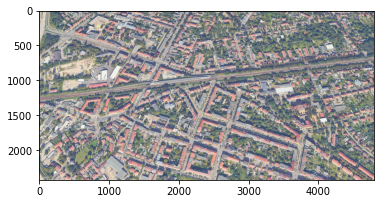

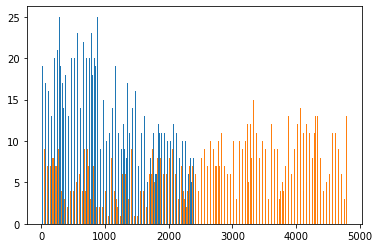

The image size is 2427x4800 pixels.
The 1383 data points are distributed along the respective axis as follows:


In [3]:
def import_image(path_raw_data, name_raw_data, raw_image_number):

    # load the image to get its shape
    orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
    i_width, i_height = orig_image.size

    # convert to numpy array
    image = img_to_array(orig_image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # load the label-points for the picture from label studio
    with open(path_raw_data+name_raw_data+'.json') as json_file:
        json_load = json.load(json_file)

    # select data
    json_load = json_load[raw_image_number]["annotations"][0]["result"]
    labels_x = ([])
    labels_y = ([])
    for i in json_load:
            labels_x = np.append(labels_x, i["value"]["x"])
            labels_y = np.append(labels_y, i["value"]["y"])
    labels_unscaled = np.vstack((labels_y, labels_x)).transpose()

    # scale data points to image pixels
    reshaper = [[(i_height/100), 0], [0,(i_width/100)]]
    labels = np.mat(labels_unscaled) * np.mat(reshaper)
    print(f"There are {labels_unscaled[:,0].shape} labeled trees in the picture")

    # show image
    plt.imshow(orig_image)
    plt.show()
    plt.close()
    # check label distribution in histogram
    plt.hist((labels), bins=200)
    plt.show()
    print(f"The image size is {i_height}x{i_width} pixels.")
    print(f"The {len(labels_x)} data points are distributed along the respective axis as follows:")

    # add row for dedicated tile
    labels = labels.astype('int')
    labels = np.hstack((labels, 0*labels[:,0]))

    return image, labels, orig_image, labels_unscaled, i_width, i_height

image, labels, orig_image, labels_unscaled, i_width, i_height = import_image(path_raw_data, name_raw_data, raw_image_number)

Matching Image and labels and show upload result

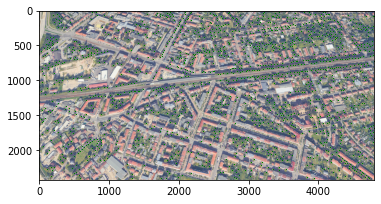

In [4]:
def show_img_with_labels(image=orig_image, labels=labels, marker=','):
    plt.imshow(image)
    # plot each labeled tree
    for dot in labels:
        #print(dot[:,1])
        plt.plot(dot[:,1], dot[:,0], marker=marker, color="green")
    # show the plot
    plt.show()

show_img_with_labels()

## Prepare tiles

OVERLAPPING

Tiles = child-pictures of image, all together represent the whole image (about twice)
- split the picture into quadratic tiles of equal size
- add second split of the picture into quadratic tiles of equal size
- tiles of different layers are stacked on top of each other shiftet by half the tile size

In [5]:
def make_tiles_small(image=image, i_width=i_width, i_height=i_height, tile_size=tile_size, border=border):

    # prepare variables for both tile layers
    ## rounded down to full tiles ignoring the last tile if it is not full:
    num_hor = int((i_width - 2 * border) // tile_size)
    num_ver = int((i_height - 2 * border) // tile_size)
    num_tiles = num_hor * num_ver
    print(f"There are {num_tiles} small tiles at {tile_size}x{tile_size} pixels")
    print(f"Small tiles identified: {num_ver} X {num_hor} tiles")

    # prepare variables for the tiles
    image = np.array(image) # input image
    tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images

    # initiate info variables
    ## store information about the tiles in total and in each layer:
    tile_dims = (num_tiles,num_ver, num_hor)
    tile_info_initial = np.zeros((num_tiles, 8)) # store information about the tiles
    ## tile_info:
        ### (tile row, tile column, true_label, probability,
        ### position horizontal, position vertical  // (top left corner of tile in the image)
        ### vertical label position, horizontal label position)

    # create tiles
    for i in range(num_ver):
        for j in range(num_hor):
            tile_num = i * num_hor + j
            # give starting (left/top) & mean pixels in rows and columns for this tile
            v_start = border + i * tile_size
            h_start = border + j * tile_size
            # create tile
            tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
            # add tile to array
            tiles[tile_num] = tile
            # store location ot tiles:
            tile_info_initial[tile_num] = (i,j,0,0,v_start, h_start, 0, 0)

    print(f"Tiles are created: {tiles.shape}.")
    return tiles, tile_info_initial, tile_dims

tiles, tile_info_initial, tile_dims = make_tiles_small()

There are 18050 small tiles at 25x25 pixels
Small tiles identified: 95 X 190 tiles
Tiles are created: (18050, 25, 25, 3).


Labels vector is created over all tiles: (18050, 1).
Tiles labeled as with tree: 1325.0
This is 7.340720221606649% of the tiles.
Total trees assigned: 1334.0.
The max number of trees per tile is: 2.0
Distribution trees per tile:


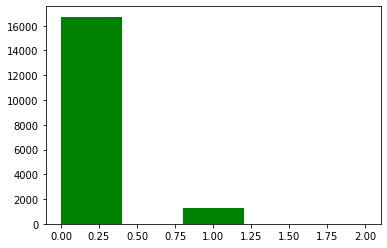

In [6]:
def label_tiles(labels=labels, tile_info_initial=tile_info_initial, tile_size=tile_size, tile_dims=tile_dims, border=border):

    # prepare variables
    num_tiles = tile_dims[0]
    max_v = int(tile_size * tile_dims[1] - 2 * border)
    max_h = int(tile_size * tile_dims[2] - 2 * border)
    tile_labels = np.zeros((num_tiles, 1)) # labels for each tile: 0 = no tree, 1 = tree
    tile_dense = np.zeros((num_tiles, 1)) # number of trees in each tile = density of a tile
    tile_info = tile_info_initial

    # Labeling the tiles
    for label in labels:
        # ignore if out of image range
        l_v = label[:,0]
        l_h = label[:,1]

        if (l_v<=max_v and l_v>border) and (l_h<=max_h and l_h>border):
            # find the tile that contains the label
            ## step through horizontal tiles alternating between layers
            pos_vertical = (l_v - border) // tile_size  # position in vertical direction
            pos_horizontal = (l_h - border) // tile_size  # position in horizontal direction
            tile_num = int((pos_vertical * tile_dims[2]) + pos_horizontal)

            # update arrays
            tile_labels[tile_num] = 1
            tile_dense[tile_num] += 1
            tile_info[tile_num][2] = 1
            label[:,2] = tile_num

    # print info on input labels
    print(f"Labels vector is created over all tiles: {tile_labels.shape}.")
    print(f"Tiles labeled as with tree: {tile_labels.sum()}")
    print(f"This is {tile_labels.sum()/tile_labels.shape[0]*100}% of the tiles.")
    print(f"Total trees assigned: {tile_dense.sum()}.")

    # show label distribution amongst tiles
    print(f"The max number of trees per tile is: {tile_dense.max()}")
    plt.hist(tile_dense, bins=5, color="green")
    print("Distribution trees per tile:")
    plt.show()
    plt.close()

    return tile_info, tile_labels

tile_info, tile_labels = label_tiles()

In [7]:
def expand_tiles(tile_info=tile_info, tile_dims=tile_dims, border=border, image=image):

    image = np.array(image) # input image
    tile_size_large = tile_size + 2 * border
    tiles_large = np.zeros((tile_dims[0], tile_size_large, tile_size_large, 3))

    for tile in range(tile_dims[0]):
        v_start = int(tile_info[tile, 4] - border)
        h_start = int(tile_info[tile, 5] - border)
        tile_large = image[v_start:v_start+tile_size_large, h_start:h_start+tile_size_large, :]
        tiles_large[tile] = tile_large
    return  tiles_large

tiles_large = expand_tiles()

The shape of the tiled picture is (95, 190)
1325.0 tiles are labeled as trees.


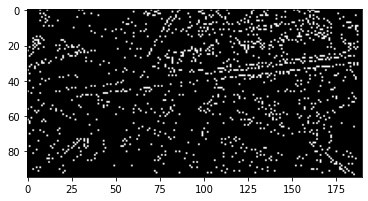

In [8]:
def show_true_tiles(tile_info=tile_info):
    # show labeled tiles
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    tiles_show = tile_info[:,2].reshape(num_ver, num_hor)
    print(f"The shape of the tiled picture is {tiles_show.shape}")
    print(f"{tile_info[:,2].sum()} tiles are labeled as trees.")
    plt.imshow(tiles_show, cmap='gray')

show_true_tiles()

Tile: 1426
The tile (top-left edge) is located at pixels 190.0 x 2415.0
Column: 96.0, Row: 7.0
label: 0.0  // prediction: 0.0
--- The inner line shows the small tile for the classification.
--- The outer, dotted line shows the large tile for the training.
--- The image line shows also adjacent tiles.


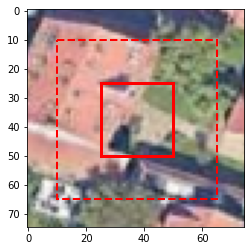

In [9]:
# show image frame around target tile
def show_target_tile(target=None, image=image, tile_info=tile_info, tile_size=tile_size, border=border):

    # choose target tile
    example = random.randint(0, len(tile_info)-1)
    if target is None: target = example
    else: target = target

    # prepare variables
    v_min = int(np.array([tile_info[target,4] - 1 * tile_size]))
    v_max = int(v_min + 3 * tile_size)
    h_min = int(np.array([tile_info[target,5] - 1 * tile_size]))
    h_max = int(h_min + 3 * tile_size)
    h_frame = tile_size # starting pixel of frame
    v_frame = tile_size

    # adjust for image borders
    if v_min < 0:
        v_min = 0
        v_frame = 0
    if h_min < 0:
        h_min = 0
        h_frame = 0
    if h_max > image.shape[1]:
        h_max = image.shape[1]
    if v_max > image.shape[0]:
        v_max = image.shape[0]

    # print info
    print(f"Tile: {target}")
    print(f"The tile (top-left edge) is located at pixels {tile_info[target,4]} x {tile_info[target,5]}")
    print(f"Column: {tile_info[target,1]}, Row: {tile_info[target,0]}")
    print(f"label: {tile_info[target,2]}  // prediction: {tile_info[target,3]}")

    # show image and frame around target tile
    image_partial = image[v_min:v_max, h_min:h_max, :]
    if tile_info[target,2] == 1: color = "green"
    else : color = "red"
    rect = patches.Rectangle(
        (h_frame, v_frame), tile_size, tile_size,
        linewidth=3, edgecolor=color, facecolor='none')
    rect_border = patches.Rectangle(
        (h_frame-border, v_frame-border),
        tile_size + 2 * border, tile_size + 2 * border,
        linewidth=2, edgecolor=color, facecolor='none', linestyle='dashed')

    plt.imshow(image_partial)
    ax = plt.gca()
    ax.add_patch(rect)
    ax.add_patch(rect_border)
    print("--- The inner line shows the small tile for the classification.")
    print("--- The outer, dotted line shows the large tile for the training.")
    print("--- The image line shows also adjacent tiles.")
    plt.show()
    plt.close()
    pass

show_target_tile()

## Prepare training and validation set

In [10]:
def make_train_set(tiles=tiles_large, tile_labels=tile_labels, tile_size=(tile_size + 2 * border), batch_size=batch_size):
    # define the training set
    train_ratio = 0.8
    num_tiles = tile_labels.shape[0]
    num_train_tiles = int(num_tiles * train_ratio)
    num_val_tiles = num_tiles - num_train_tiles
    print(f"There are {num_tiles} tiles in total.")
    print(f"There are {num_train_tiles} tiles in the training set.")
    print(f"There are {num_val_tiles} tiles in the validation set.")

    # split into training and validation set
    train_tiles = tiles[:int(num_tiles*train_ratio)]
    train_labels = tile_labels[:int(num_tiles*train_ratio)]
    val_tiles = tiles[int(num_tiles*train_ratio):]
    val_labels = tile_labels[int(num_tiles*train_ratio):]
    print(f"Training set: {train_tiles.shape} - ({train_ratio} share of all tiles)")
    print(f"Validation set: {val_tiles.shape}")

    # build tensorflow dataset
    dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
    dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

    # shuffle and batch
    def encode(tile, label):
        image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
        image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
        return image_encoded, label

    dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(2500).batch(batch_size)
    dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

    return dataset_train, dataset_validate

dataset_train, dataset_validate = make_train_set()

There are 18050 tiles in total.
There are 14440 tiles in the training set.
There are 3610 tiles in the validation set.
Training set: (14440, 55, 55, 3) - (0.8 share of all tiles)
Validation set: (3610, 55, 55, 3)


2022-06-09 22:12:05.825218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 22:12:05.825236: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 22:12:05.825251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Luise): /proc/driver/nvidia/version does not exist
2022-06-09 22:12:05.825460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-09 22:12:05.826191: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1048344000 exceeds 10

-------
# Training

----



## model


In [11]:
def make_model_base(tile_size=(tile_size + 2 * border)):

    METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
    initializer = tf.keras.initializers.GlorotUniform(seed=42)

    model = models.Sequential()

    model.add(layers.Input(shape=(tile_size, tile_size, 3)))
    model.add(layers.Conv2D(20, (3,3), activation="relu", padding="same"))
    model.add(layers.Conv2D(30, (3,3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=initializer))
    model.summary()

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer="adam",
        metrics=METRICS,

        )
    return model, METRICS

model, METRICS = make_model_base()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 20)        560       
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 30)        5430      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 30)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 21870)             0         
                                                                 
 dense (Dense)               (None, 150)               3280650   
                                                                 
 dense_1 (Dense)             (None, 20)                3020      
                                                        

## Train a model

In [12]:
def train_model(model_name="latest", model=model, dataset_train=dataset_train, dataset_validate=dataset_validate, epochs=30):

    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_validate,
    )
    model.save(model_name)
    return model, history, model_name

model, history, model_name = train_model(model_name="model_base_1")

2022-06-09 22:12:06.453645: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1048344000 exceeds 10% of free system memory.


Epoch 1/30
49/49 [==============================] - 43s 857ms/step - loss: 0.2632 - binary_accuracy: 0.9084 - precision: 0.1217 - recall: 0.0244 - val_loss: 0.1543 - val_binary_accuracy: 0.9510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
49/49 [==============================] - 40s 821ms/step - loss: 0.2084 - binary_accuracy: 0.9224 - precision: 0.6400 - recall: 0.0557 - val_loss: 0.1377 - val_binary_accuracy: 0.9526 - val_precision: 0.5882 - val_recall: 0.1130
Epoch 3/30
49/49 [==============================] - 40s 809ms/step - loss: 0.1909 - binary_accuracy: 0.9266 - precision: 0.6294 - recall: 0.1864 - val_loss: 0.1377 - val_binary_accuracy: 0.9529 - val_precision: 0.6842 - val_recall: 0.0734
Epoch 4/30
49/49 [==============================] - 35s 714ms/step - loss: 0.1805 - binary_accuracy: 0.9287 - precision: 0.6621 - recall: 0.2117 - val_loss: 0.1324 - val_binary_accuracy: 0.9529 - val_precision: 0.5745 - val_recall: 0.1525
Epoch 5/30
49/49 [==================

INFO:tensorflow:Assets written to: model_base_1/assets


INFO:tensorflow:Assets written to: model_base_1/assets


In [13]:
def render_history(history=history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["precision"], label="precision")
    plt.plot(history["val_precision"], label="val_precision")
    plt.legend()
    plt.title("Our precision")
    plt.show()
    plt.close()
    pass

def compare_histories(history_list=history_list):
    for training_name, history in history_list.items():
        plt.plot(history["val_binary_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()
    pass

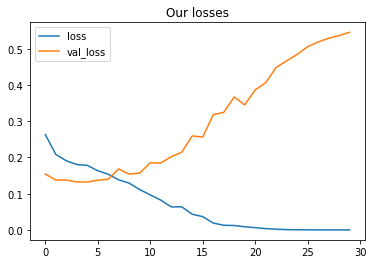

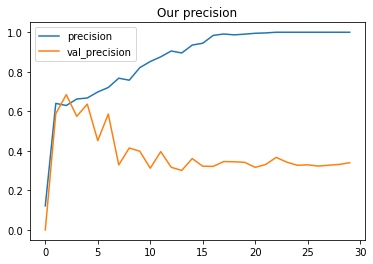

In [14]:
render_history(history.history)

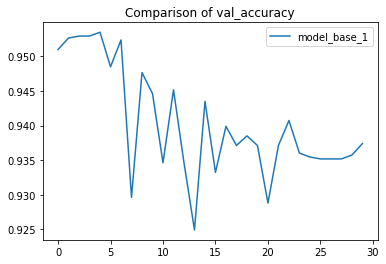

In [15]:
history_list[model_name] = history.history
compare_histories()
tf.keras.backend.clear_session()

-------------------------
# Predict

-----

## predict on training data

In [17]:
# predict
threshold = 0.2
probabilities = model.predict(tiles_large)
predictions = [1 if x >= threshold else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]

2022-06-09 22:33:13.152593: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 655215000 exceeds 10% of free system memory.


565/565 [==============================] - 7s 13ms/step


In [18]:
# save predictions
np.savetxt(f'prediction_{name_raw_data}_{model_name}.txt', predictions)

In [19]:
def perf_measure(y_actual=tile_info[:,2], y_hat=predictions):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num_tiles = len(y_actual)
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    print(f"TP: {int(TP/num_tiles*100)}%,  FP: {int(FP/num_tiles*100)}%,  TN: {int(TN/num_tiles*100)}%,  FN: {int(FN/num_tiles*100)}%")
    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure()


TP: 1208, FP: 129, TN: 16596, FN: 117
TP: 6%,  FP: 0%,  TN: 91%,  FN: 0%


1337 out of 18050 tiles we predicted as with trees!
This is 0.0007407202216066481% of the tiles


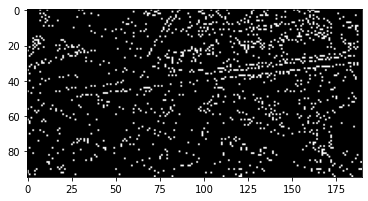

In [20]:
def show_pred_tiles(predictions=predictions, tile_info=tile_info):
    # show prediction of tiles
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    tiles_show = predictions.reshape(num_ver, num_hor)
    plt.imshow(tiles_show, cmap='gray')
    num_pos = predictions.sum()
    print(f"{num_pos} out of {len(predictions)} tiles we predicted as with trees!")
    print(f"This is {num_pos / len(predictions)/100}% of the tiles")
    pass

show_pred_tiles()

1337 trees identified


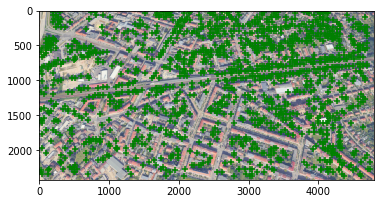

In [21]:
def show_img_with_pred(tile_info=tile_info, threshold=threshold, image=orig_image):
    plt.imshow(image)
    pred_pixels = [] # list of pixels of identified trees
    for tree in tile_info:
        if tree[3] >= threshold:
            plt.scatter(tree[5], tree[4], marker='+',  c="green")
            pred_pixels.append((tree[5], tree[4]))
    print(f"{len(pred_pixels)} trees identified")
    plt.show()
    plt.close()
    return pred_pixels

pred_pixels = show_img_with_pred()

## Test on images

In [26]:
# load the image to get its shape
name_raw_data = "Potsdam_02"
orig_image_2 = load_img(path_raw_data+name_raw_data+'.jpg')
i_width, i_height = orig_image_2.size
# convert to numpy array
image_2 = img_to_array(orig_image_2)
# scale pixel values to [0, 1]
image_2 = image_2.astype('float32')
image_2 /= 255.0

In [27]:
# define the tile size

num_horizontal_tiles = i_width // tile_size
num_vertical_tiles = i_height // tile_size
num_tiles = num_horizontal_tiles * num_vertical_tiles
print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
print(f"There are {num_horizontal_tiles} horizontal tile columns and {num_vertical_tiles} vertical tile rows")

# prepare variables for the tiles
image_2 = np.array(image_2) # input image
tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
tile = np.zeros((tile_size, tile_size, 3)) # image of tile
tile_info = np.zeros((num_tiles, 6)) # (tile row, tile column, true_label, probability, x_mean, y_mean)

# create tiles
for i in tq(range(num_vertical_tiles)):
    for j in range(num_horizontal_tiles):
        tile_num = i * num_horizontal_tiles + j
        # give starting (left/top) & mean pixels in rows and columns for this tile
        v_start = i * tile_size
        h_start = j * tile_size
        v_mean = v_start + tile_size // 2
        h_mean = h_start + tile_size // 2
        # create tile
        tile = image_2[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
        # add tile to array
        tiles[tile_num] = tile
        # store location ot tiles:
        tile_info[tile_num] = (i,j,0,0,v_mean, h_mean)

print(f"Tiles are created: {tiles.shape}.")

There are 18624 tiles at 25x25 pixels
There are 192 horizontal tile columns and 97 vertical tile rows


100%|██████████| 97/97 [00:00<00:00, 464.43it/s]

Tiles are created: (18624, 25, 25, 3).


In [24]:
# predict
threshold = 0.45
probabilities_2 = model.predict(tiles_large)
predictions_2 = [1 if x >= threshold else 0 for x in probabilities_2]
predictions_2 = np.array(predictions_2)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities_2[:,0]
#count true predictions
true_predictions = sum(1 if x == y else 0 for x, y in zip(predictions, tile_labels))
#true_predictions_count = sum(true_predictions)
#print(f"True trees: {tile_count.sum()}")
#print(f"Predictions: {true_predictions_count} out of {len(predictions)} tiles are identified as with trees.")
# show labeled tiles
tiles_show = predictions_2.reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show, cmap='gray')

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 508, in dispatch_queue
      await self.process_one()
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 497, in process_one
      await dispatch(*args)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 404, in dispatch_shell
      await result
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 728, in execute_request
      reply_content = await reply_content
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_263034/3660355508.py", line 3, in <cell line: 3>
      probabilities_2 = model.predict(tiles)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/keras/layers/reshaping/flatten.py", line 98, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 138240 values, but the requested shape requires a multiple of 21870
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_predict_function_19630]

In [ ]:
plt.imshow(orig_image_2)